In [12]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.optim as optim
import random
import time
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,precision_recall_fscore_support,auc
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
path = "/content/gdrive/MyDrive/MaskNomaskdataset/tiny-imagenet-200.zip"
import zipfile
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('/content/tinyimgnet')

In [21]:
config = dict(
    train_data = "/content/tinyimgnet/tiny-imagenet-200/train",
    test_data = "/content/tinyimgnet/tiny-imagenet-200/val/images",
    test_anno="/content/tinyimgnet/tiny-imagenet-200/val/val_annotations.txt",
    wnids = "/content/tinyimgnet/tiny-imagenet-200/wnids.txt",
    lr = 0.001,
    EPOCHS = 10,
    BATCH_SIZE = 32,
    IMAGE_SIZE = 64,
    pin_memory = True,
    num_workers = 2,
    SEED = 42,
    GPU_ID=0,
    val_split = 0.2
)

In [22]:
class CustomTestDataset():
  def __init__(self,img_path):
    self.img_path = img_path
    with open(config['wnids']) as f:
      self.wnids = f.read().split('\n')
      self.wnids.remove('')

    with open(config['test_anno']) as f:
      self.test_anno = list(map(lambda x:x.split('\t')[:2],f.read().split("\n")))
      self.test_anno.remove([''])

    self.wnids = sorted(self.wnids,key = lambda x:x)
    self.mapping = dict(list(zip(self.wnids,list(range(200)))))
    # self.rev_mapping = {j:i for i,j in self.mapping.items()}
    self.transformations = transforms.ToTensor()

  def __len__(self):
    return len(self.test_anno)

  def __getitem__(self,idx):
    test_img, class_name = self.test_anno[idx]
    cls_idx = self.mapping.get(class_name,-1)
    
    img = Image.open(os.path.join(config['test_data'],test_img)).convert('RGB')
    img = self.transformations(img)
    return (img,cls_idx)

class CustomTrainDataset():
  def __init__(self,img_path):
    self.img_path = img_path
    with open(config['wnids']) as f:
      self.wnids = f.read().split('\n')
      self.wnids.remove('')
    self.wnids = sorted(self.wnids,key = lambda x:x)
    self.mapping = dict(list(zip(self.wnids,list(range(200)))))

    img_class = os.listdir(self.img_path)
    self.img_map = []
    for clss in img_class:
      cls_imgs = os.listdir(os.path.join(self.img_path,clss,'images'))
      clss_imgs = list(map(lambda x:[clss,x],cls_imgs))
      self.img_map.extend(clss_imgs)
    
    self.transformations = transforms.ToTensor()
  def __len__(self):
    return len(self.img_map)

  def __getitem__(self,idx):
    class_image,image_name = self.img_map[idx]
    cls_idx = self.mapping.get(class_image,-1)

    img = Image.open(os.path.join(self.img_path,class_image,'images',image_name)).convert('RGB')
    img = self.transformations(img)

    return (img,cls_idx)
# ctd = CustomTestDataset(config['test_data'])
# test_loader = torch.utils.data.DataLoader(ctd,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])
# cTd = CustomTrainDataset(config['train_data'])
# print(len(cTd))
# train_loader = torch.utils.data.DataLoader(cTd,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])


In [23]:

device = torch.device(f'cuda:{config["GPU_ID"]}' if torch.cuda.is_available() else 'cpu')
print(device)

config['DEVICE'] = device

torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])


transformations = {
  'train':torchvision.transforms.Compose([
          torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'test':torchvision.transforms.Compose([
          torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
}

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

cuda:0


In [24]:
def get_params(model):
  par = 0
  for params in model.parameters():
    if (params.requires_grad == True):
      par += params.numel()
  return par

class D_ce(nn.Module):
  def __init__(self,num_class=200):
    super(D_ce,self).__init__()
    self.n_class = num_class
    self.dnet = torchvision.models.densenet121(pretrained=True)
    self.dnet.classifier = nn.Linear(1024,self.n_class)
    print(get_params(self.dnet))

    for name,params in self.dnet.named_parameters():
      if (name == "features.denseblock4.denselayer16.norm1.weight"):
        break
      params.requires_grad = False

    print(get_params(self.dnet))

  def forward(self,x):
    x = self.dnet(x)
    return x



In [44]:
def train(model,train_load,lossfunction,optimizer,n_epochs=200):
    tval = {'trainacc':[],"trainloss":[]}
    starttime = time.time()
    for epochs in range(n_epochs):
        model.train()
        cur_loss = 0
        curacc = 0
        len_train = len(train_load)
        for idx , (data,target) in enumerate(train_load):
            data = transformations['train'](data)    
            data = data.to(device)
            target = target.to(device)
            # model = model.to(device)

            scores = model(data)    
            loss = lossfunction(scores,target)
            cur_loss += loss.item() / (len_train)
            scores = F.softmax(scores,dim = 1)
            _,predicted = torch.max(scores,dim = 1)
            correct = (predicted == target).sum()
            samples = scores.shape[0]
            curacc += correct / (samples * len_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print('TrainBatchDone:{:d}'.format(idx),end='\r') 
  
        tval['trainacc'].append(float(curacc))
        tval['trainloss'].append(float(cur_loss))
      
        print('epoch:[{:d}/{:d}], TrainAcc:{:.3f}, TrainLoss:{:.3f}'.format(epochs+1,n_epochs,curacc,cur_loss)) 

    time2 = time.time() - starttime
    print('done time {:.3f} Mins'.format(time2/60))
    return tval

def evaluate(model,loader,name='test'):
  model.eval()
  correct = 0;samples =0
  pre_prob = []
  lab = []
  predicted_labels = []

  with torch.no_grad():
      for idx,(x,y) in enumerate(loader):
          x = transformations['test'](x)
          x = x.to(device)
          y = y.to(device)
          # model = model.to(device)

          scores = model(x)
          predict_prob = F.softmax(scores)
          _,predictions = predict_prob.max(1)

          predictions = predictions.to('cpu')
          y = y.to('cpu')
          predict_prob = predict_prob.to('cpu')

          predicted_labels.extend(list(predictions.numpy()))
          pre_prob.extend(list(predict_prob.numpy()))
          lab.extend(list(y.numpy()))

          correct += (predictions == y).sum()
          samples += predictions.size(0)

          print('batches done : ',idx,end='\r')
      
      print(f'correct are {correct/samples:.3f}')
      
  model.train()
  return np.array(lab),np.array(predicted_labels),np.array(pre_prob)

def plot_loss_acc(tval):
  plt.figure(figsize=(5,4))
  plt.plot(list(range(1,config['EPOCHS']+1)),tval['trainloss'],label='loss')
  plt.plot(list(range(1,config['EPOCHS']+1)),tval['trainacc'],label='accuracy')
  plt.xlabel('epochs')
  plt.ylabel('loss/accuracy')
  plt.title('loss_accuracy')
  plt.legend()
  plt.savefig('loss_acc_2b.svg',format='svg')
  plt.show()

In [29]:
ctd = CustomTestDataset(config['test_data'])
test_loader = torch.utils.data.DataLoader(ctd,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])
cTd = CustomTrainDataset(config['train_data'])
train_set,_ = torch.utils.data.dataset.random_split(cTd,[50000,50000])
train_loader = torch.utils.data.DataLoader(cTd,batch_size=config['BATCH_SIZE'],shuffle=True,num_workers=config['num_workers'],pin_memory=config['pin_memory'])


In [31]:
dnet = D_ce()
dnet = dnet.to(device)

lossfunction = nn.CrossEntropyLoss()
optimizer = optim.Adam(dnet.parameters(),lr=config['lr'])
history = train(dnet,train_loader,lossfunction,optimizer,n_epochs=config['EPOCHS'])
# print(dnet(torch.rand(2,3,64,64).to(device)).shape)

7158856
373128
epoch:[1/10], TrainAcc:0.340, TrainLoss:2.913
epoch:[2/10], TrainAcc:0.441, TrainLoss:2.319
epoch:[3/10], TrainAcc:0.478, TrainLoss:2.126
epoch:[4/10], TrainAcc:0.500, TrainLoss:2.000
epoch:[5/10], TrainAcc:0.517, TrainLoss:1.916
epoch:[6/10], TrainAcc:0.531, TrainLoss:1.848
epoch:[7/10], TrainAcc:0.542, TrainLoss:1.790
epoch:[8/10], TrainAcc:0.551, TrainLoss:1.747
epoch:[9/10], TrainAcc:0.559, TrainLoss:1.708
epoch:[10/10], TrainAcc:0.565, TrainLoss:1.680
done time 28.241 Mins


In [34]:
y_true,y_pred,pred_prob = evaluate(dnet,test_loader)

correct are 0.478


In [35]:
precision,recall,f_score,_ = precision_recall_fscore_support(y_true,y_pred)

In [36]:
print(precision)
    

[0.74074074 0.58928571 0.4047619  0.25252525 0.43396226 0.22619048
 0.65957447 0.51612903 0.78571429 0.63636364 0.43181818 0.52307692
 0.6097561  0.8        0.67307692 0.43137255 0.35483871 0.53448276
 0.34920635 0.58823529 0.59090909 0.81818182 0.63461538 0.76470588
 0.40425532 0.49315068 0.52727273 0.44       0.54761905 0.51851852
 0.3        0.70588235 0.61538462 0.36363636 0.47272727 0.575
 0.65217391 0.52272727 0.54166667 0.24528302 0.29411765 0.45
 0.2962963  0.4        0.66666667 0.68965517 0.55357143 0.59259259
 0.5        0.45454545 0.59677419 0.55555556 0.57692308 0.53333333
 0.49152542 0.54545455 0.51351351 0.65853659 0.68627451 0.49122807
 0.51785714 0.56818182 0.35416667 0.46666667 0.39130435 0.21666667
 0.57894737 0.43333333 0.32631579 0.25974026 0.28888889 0.76666667
 0.39344262 0.43333333 0.34848485 0.57894737 0.52941176 0.5
 0.609375   0.31147541 0.4047619  0.77192982 0.35064935 0.4
 0.54166667 0.39473684 0.6969697  0.44       0.36363636 0.48148148
 0.53571429 0.424657

In [37]:
print(recall)

[0.8  0.66 0.34 0.5  0.46 0.38 0.62 0.32 0.66 0.28 0.38 0.68 0.5  0.72
 0.7  0.44 0.22 0.62 0.44 0.6  0.52 0.72 0.66 0.78 0.38 0.72 0.58 0.22
 0.46 0.28 0.36 0.48 0.16 0.4  0.52 0.46 0.6  0.46 0.52 0.52 0.2  0.36
 0.32 0.36 0.68 0.8  0.62 0.64 0.28 0.3  0.74 0.4  0.6  0.48 0.58 0.6
 0.38 0.54 0.7  0.56 0.58 0.5  0.34 0.56 0.36 0.26 0.44 0.26 0.62 0.4
 0.52 0.46 0.48 0.52 0.46 0.44 0.36 0.22 0.78 0.38 0.34 0.88 0.54 0.4
 0.26 0.6  0.46 0.44 0.4  0.52 0.6  0.62 0.46 0.38 0.18 0.4  0.44 0.52
 0.52 0.28 0.32 0.64 0.38 0.66 0.54 0.18 0.36 0.64 0.76 0.56 0.58 0.64
 0.32 0.5  0.26 0.74 0.28 0.58 0.64 0.2  0.2  0.54 0.5  0.2  0.72 0.22
 0.44 0.54 0.54 0.56 0.52 0.1  0.16 0.6  0.38 0.08 0.44 0.4  0.38 0.18
 0.54 0.38 0.34 0.8  0.44 0.88 0.74 0.4  0.54 0.58 0.44 0.28 0.7  0.54
 0.58 0.38 0.44 0.56 0.38 0.18 0.34 0.46 0.5  0.4  0.64 0.68 0.6  0.38
 0.24 0.5  0.54 0.34 0.18 0.58 0.38 0.16 0.6  0.5  0.62 0.4  0.34 0.46
 0.3  0.42 0.74 0.56 0.72 0.48 0.52 0.58 0.42 0.56 0.74 0.76 0.52 0.56
 0.74 0.3

In [39]:
print(f_score)

[0.76923077 0.62264151 0.36956522 0.33557047 0.44660194 0.28358209
 0.63917526 0.39506173 0.7173913  0.38888889 0.40425532 0.59130435
 0.54945055 0.75789474 0.68627451 0.43564356 0.27160494 0.57407407
 0.38938053 0.59405941 0.55319149 0.76595745 0.64705882 0.77227723
 0.39175258 0.58536585 0.55238095 0.29333333 0.5        0.36363636
 0.32727273 0.57142857 0.25396825 0.38095238 0.4952381  0.51111111
 0.625      0.4893617  0.53061224 0.33333333 0.23809524 0.4
 0.30769231 0.37894737 0.67326733 0.74074074 0.58490566 0.61538462
 0.35897436 0.36144578 0.66071429 0.46511628 0.58823529 0.50526316
 0.53211009 0.57142857 0.43678161 0.59340659 0.69306931 0.52336449
 0.54716981 0.53191489 0.34693878 0.50909091 0.375      0.23636364
 0.5        0.325      0.42758621 0.31496063 0.37142857 0.575
 0.43243243 0.47272727 0.39655172 0.5        0.42857143 0.30555556
 0.68421053 0.34234234 0.36956522 0.82242991 0.42519685 0.4
 0.35135135 0.47619048 0.55421687 0.44       0.38095238 0.5
 0.56603774 0.5040650

In [42]:
print(f'precision: {np.array(precision).mean():.3f}')
print(f'recall: {np.array(recall).mean():.3f}')
print(f'f_score: {np.array(f_score).mean():.3f}')

precision: 0.501
recall: 0.478
f_score: 0.476


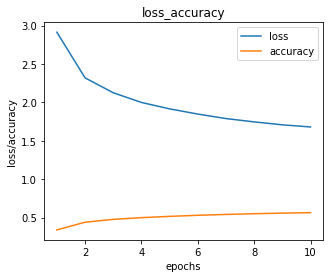

In [45]:
plot_loss_acc(history)